In [102]:
from RBFNN import RBFNN, ModelType
from dataset.chaotic_system import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from utils import *
import copy
import os
import time


class Dict(dict):
    __setattr__ = dict.__setitem__
    __getattr__ = dict.__getitem__


names = [
    'rossler',
    'rabinovich_fabrikant',
    'lorentz',
#     'chen',
    'chua',
    # 'switch'
]
# names = [n + '1d' for n in names]

n_dim = 3
horizon = 1
N = 10000
N_h = 200
num_prepare = 1000
num_train = 2000
num_test = 2000
train_start = 0
test_start = 5000
np.random.seed()
nz = 100
connectivity = 1
reservoirConf = Dict(
    alpha=0.9,
    connectivity= connectivity,
    nz= nz,
    nu = n_dim,
    target_rho=0.99,
    input_scale= 1
)

path = 'result/how many history are needed for ESN'
if not os.path.exists(path):
    os.makedirs(path)

for file in range(10):
    result_file = path + '/result_'+str(file) + '.csv'
    if os.path.exists(result_file):
        result = pd.read_csv(result_file)
    else:
        result = pd.DataFrame(columns=['datetime', 'system_name',  'n_dim', 'n_history', 'horizon', 'model_name', 'N_h', 'sigma','reservoir_encoder','nz', 'connectivity', 'mse'])

    process_start_time = time.time()
    print('第{}轮'.format(file))
    for system_name in names:
        for n_history in [1,2,3,4,5,6,7,8,9,10,15,20,30,50,80,100]:
        
            '''
            数据集
            '''
            x = np.loadtxt('dataset/'+system_name+'.txt', delimiter=',').T
            x += np.random.randn(*x.shape)*0.001

            x_train = np.vstack([select_samples(x, train_start + i, num_train+num_prepare) for i in range(n_history)])
            y_train = select_samples(x, train_start+num_prepare + n_history + horizon - 1, num_train)
            x_test = np.vstack([select_samples(x, test_start + i, num_test+num_prepare) for i in range(n_history)])
            y_test = select_samples(x, test_start+num_prepare + n_history + horizon - 1, num_test) 


            rc = reservoirConf

#             print('train set:', x_train.shape, y_train.shape)
#             print('test  set:', x_test.shape, y_test.shape)


            '''
            单步预测
            '''
            model_confs = []
            model_confs += [('ESN', 
                             ModelType.ESN, 
                             dict(reservoirConf=rc,encoder='transform'))]
            
            model_confs += [('ESN-1000', 
                             ModelType.ESN, 
                             dict(reservoirConf=rc,encoder='echostate'))]

#             model_confs += [('RBFLN-RE', 
#                              ModelType.RBFLN_RE, 
#                              dict(N_h=N_h, sigma=sigma, reservoirConf=rc, encoder='transform'))
#                             for sigma in [ 1 / 8, 1 / 4, 1 / 2, 1, 2, 4, 8]]
            
#             model_confs += [('ESN-ATTN',
#                              ModelType.ESN_ATTN, 
#                              dict(N_h=N_h, sigma=sigma, reservoirConf=rc,encoder='transform'))
#                             for sigma in [ 1 / 8, 1 / 4, 1 / 2, 1, 2, 4, 8]]

            model_names = [conf[0] for conf in model_confs]

            colors = list(cnames.keys())

            Predictions = [np.empty((n_dim, num_test)) for _ in range(len(model_confs))]
            MSE = [0.0] * len(model_confs)

            for j, conf in enumerate(model_confs):
                model_name, model_type, kwargs = conf
                conf_dict = dict(
                    model_type=model_type,
                    **kwargs
                )

                model = RBFNN(**conf_dict)

                model.train(x_train, y_train, num_prepare)

                Predictions[j] = model.predict(x_test, num_prepare)

                MSE[j] = mse(Predictions[j], y_test)

                result.loc[result.shape[0]] = {
                    'datetime'          : pd.datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
                    'system_name'       : system_name,
                    'n_dim'             : n_dim,
                    'n_history'         : n_history,
                    'horizon'           : horizon,
                    'model_name'        : model_name,
                    'N_h'               : N_h,
                    'sigma'             : kwargs.get('sigma', 0),
                    'nz'                : nz,
                    'connectivity'      : connectivity,
                    'reservoir_encoder' : 0 if rc is None else 1,
                    'mse'               : MSE[j]
                }
#                 print(result.loc[result.shape[0]-1])



    result.to_csv(result_file, index=False)
    process_stop_time = time.time()

    # 差的时间戳
    diff_time = process_stop_time - process_start_time
    # 将计算出来的时间戳转换为结构化时间
    struct_time = time.gmtime(diff_time)
    # 减去时间戳最开始的时间 并格式化输出
    print('数据处理用了{0}年{1}月{2}日{3}小时{4}分钟{5}秒'.format(
        struct_time.tm_year - 1970,
        struct_time.tm_mon - 1,
        struct_time.tm_mday - 1,
        struct_time.tm_hour,
        struct_time.tm_min,
        struct_time.tm_sec
    ))

第0轮
数据处理用了0年0月0日0小时0分钟34秒
第1轮
数据处理用了0年0月0日0小时0分钟31秒
第2轮
数据处理用了0年0月0日0小时0分钟31秒
第3轮
数据处理用了0年0月0日0小时0分钟31秒
第4轮
数据处理用了0年0月0日0小时0分钟31秒
第5轮
数据处理用了0年0月0日0小时0分钟31秒
第6轮
数据处理用了0年0月0日0小时0分钟31秒
第7轮
数据处理用了0年0月0日0小时0分钟31秒
第8轮
数据处理用了0年0月0日0小时0分钟31秒
第9轮
数据处理用了0年0月0日0小时0分钟31秒


# result analysis

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime



system_names = ['rossler','rabinovich_fabrikant','lorentz','chua']
# system_names = [system + '1d' for system in system_names]

path = 'result/how many history are needed for ESN'

result_file0 = path + '/result_0.csv' 
df = pd.read_csv(result_file0, index_col = 'datetime')
df.index = pd.DatetimeIndex(df.index)
set(df['model_name'])
df

,system_name,n_dim,n_history,horizon,model_name,N_h,sigma,reservoir_encoder,nz,connectivity,mse
datetime,,,,,,,,,,,
2020-07-30 20:20:01,rossler,3,1,1,ESN,200,0,1,100,1,0.000002
2020-07-30 20:20:01,rossler,3,1,1,ESN-1000,200,0,1,100,1,0.000002
2020-07-30 20:20:01,rossler,3,2,1,ESN,200,0,1,100,1,0.000002
2020-07-30 20:20:01,rossler,3,2,1,ESN-1000,200,0,1,100,1,0.000002
2020-07-30 20:20:01,rossler,3,3,1,ESN,200,0,1,100,1,0.000001
...,...,...,...,...,...,...,...,...,...,...,...
2020-07-31 09:39:59,chua,3,50,1,ESN-1000,200,0,1,100,1,0.000007
2020-07-31 09:40:00,chua,3,80,1,ESN,200,0,1,100,1,0.000007
2020-07-31 09:40:00,chua,3,80,1,ESN-1000,200,0,1,100,1,0.000007


rossler


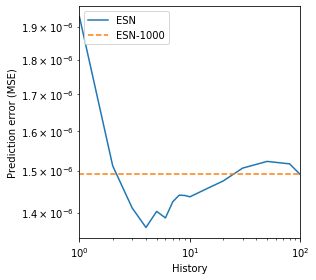

rabinovich_fabrikant


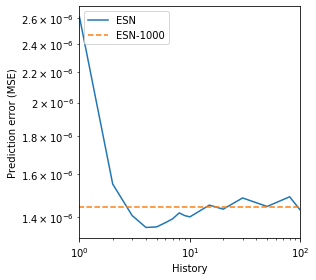

lorentz


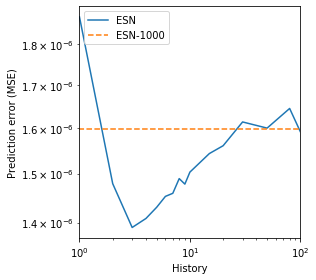

chua


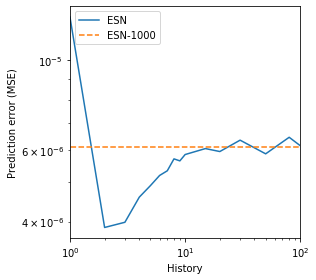

In [104]:
for system_name in system_names:
    print(system_name)

    model_names = ['ESN', 'ESN-1000']

    average = pd.DataFrame()
    for i in range(10):
        result_file = path + '/result_' +str(i) + '.csv' 
        df = pd.read_csv(result_file, index_col = 'datetime')
        df.index = pd.DatetimeIndex(df.index)

        result = df[df['system_name'].isin([system_name]) & 
                    df['model_name'].isin(model_names) & 
                    df['n_history'].isin([1,2,3,4,5,6,7,8,9,10,15,20,30,50,80,100]) &
                    df['horizon'].isin(list(range(11)))]


        final = None
        for w in set(result['n_history']):

            temp = result.loc[result['n_history'] == w, ['model_name', 'mse', 'n_history']].groupby('model_name').min().reset_index()

            final = temp if final is None else final.append(temp, ignore_index=True)

        average = average.append(final,ignore_index=True)
    
    fig, ax = plt.subplots(figsize=(4.5,4))
    models1 = ['ESN',]
    models2 = ['ESN-1000']
    
    for name in models1:
        average.loc[average['model_name'] == name].groupby('n_history').mean().sort_values(by='n_history').plot(ax = ax)

    for name in models2:
        esn = average.loc[average['model_name'] == name].groupby('n_history').mean().mean()
        plt.plot([0,200], [esn,esn], '--', label=name)
    
    plt.legend(labels= models1+models2, loc='upper left')
    ax.set_yscale("log")
    ax.set_xscale("log")
    plt.xlabel('History')
    plt.ylabel('Prediction error (MSE)')
#     plt.xticks([5,10,15])
    plt.tight_layout()

    plt.savefig(path+'/'+system_name+'_esn_history.pdf')
    plt.show()